
## What is a Breakeven Point?

Think of a breakeven point like the "break-even price" for a business - it's the stock price where your options strategy neither makes money nor loses money. 

**Example:** If you buy a call option at strike 100 for ₹5 premium, your breakeven is 105 (strike + premium). The stock needs to go above 105 for you to profit.

## What is the Safestrike Tool Trying to Solve?

Imagine you have an existing options position (like a straddle or strangle), and someone recommends: *"Hey, you should move your breakeven to 18,500"*

**The Problem:** Your current breakeven might be at 18,200, but you want it at 18,500. How do you adjust your existing position to achieve this new breakeven?

**The Manual Way:** You'd have to:
1. Calculate what additional options to buy/sell
2. Figure out how much it costs
3. Check if it's worth the risk (Greeks analysis)
4. Do this trial-and-error for multiple scenarios

**The Safestrike Way:** The tool does all this automatically and shows you the best options ranked by risk/reward.

## How Will Our Solution Work?

### Step 1: Understand Current Position
- Take your existing options positions
- Calculate current breakeven points (there might be 2 for strategies like straddles)
- Calculate current Greeks (Delta, Gamma, Theta, Vega)

### Step 2: Target Adjustment
- You specify the desired breakeven (e.g., 18,500)
- The tool calculates: "What additional positions do I need to shift my breakeven to exactly 18,500?"

### Step 3: Generate Adjustment Options
The tool will try different combinations:
- Buy/Sell Call options at various strikes
- Buy/Sell Put options at various strikes  
- Different quantities (1x, 2x, 3x, etc.)

### Step 4: Rank by Efficiency
For each possible adjustment, calculate:
- **Cost:** How much does this adjustment cost?
- **Theta/Gamma Ratio:** This tells us risk efficiency
  - **Theta:** How much money you lose per day (time decay)
  - **Gamma:** How much your Delta changes (profit acceleration)
  - **Lower Theta/Gamma = Better** (less time decay per unit of profit potential)

### Step 5: Present Top Results
Show you the top 5-10 adjustment options ranked by best Theta/Gamma ratio.

## Why This Solution Will Work

### 1. **Mathematical Precision**
- Breakeven calculation is pure math: it's where P&L = 0
- We can solve this equation exactly for any combination of options

### 2. **Greeks-Based Ranking**
- Theta/Gamma ratio is a proven metric in options trading
- It gives objective comparison between different strategies

### 3. **Automation**
- Instead of manual trial-and-error, we systematically test all possibilities
- Computer can evaluate hundreds of combinations in seconds

### 4. **Real Market Data**
- Uses live option prices and implied volatility
- Accounts for bid-ask spreads and real trading costs

## Simple Example

**Current Position:** Long Straddle at 18,000 (bought 1 Call + 1 Put)
- Current Breakevens: 17,800 and 18,200
- Current Cost: ₹400

**Target:** Move upper breakeven to 18,500

**Possible Adjustments:**
1. **Sell 1 Call at 18,300** → Cost: -₹150, New breakeven: 18,450, Theta/Gamma: 0.8
2. **Buy 1 Call at 18,800** → Cost: +₹80, New breakeven: 18,480, Theta/Gamma: 1.2  
3. **Sell 2 Calls at 18,400** → Cost: -₹200, New breakeven: 18,500, Theta/Gamma: 0.6

**Result:** Option 3 is best (lowest Theta/Gamma ratio)



In [8]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import logging
from dataclasses import dataclass
from typing import List, Optional, Tuple

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Create a simplified OptionLeg class (instead of importing)
@dataclass
class OptionLeg:
    symbol: str
    strike: float
    option_type: str  # 'CE' or 'PE'
    entry_price: float
    quantity: int
    lot_size: int = 1
    
    @property
    def total_quantity(self):
        return self.quantity * self.lot_size

# Define our own version of the combined_payoff function
def combined_payoff(legs: List[OptionLeg], spot_price: float) -> float:
    """
    Calculate combined P&L for a list of option legs at a given spot price.
    
    Args:
        legs: List of OptionLeg objects
        spot_price: Current price of the underlying
        
    Returns:
        float: Total P&L across all legs
    """
    total_pnl = 0
    
    for leg in legs:
        # Calculate intrinsic value at expiry
        if leg.option_type == "CE":  # Call option
            intrinsic = max(0, spot_price - leg.strike)
        else:  # Put option
            intrinsic = max(0, leg.strike - spot_price)
            
        # Calculate P&L per contract
        contract_pnl = intrinsic - leg.entry_price
        
        # Total P&L for this leg
        leg_pnl = contract_pnl * leg.total_quantity
        
        total_pnl += leg_pnl
        
    return total_pnl

# Define our own version of the find_breakeven_points function
def find_breakeven_points(legs: List[OptionLeg], 
                         price_range: Optional[Tuple[float, float]] = None,
                         precision: float = 0.01) -> List[float]:
    """
    Find all breakeven points for a combination of option legs.
    
    Args:
        legs: List of OptionLeg objects
        price_range: Optional tuple with (min_price, max_price) to search
        precision: Precision for the search
        
    Returns:
        List of breakeven prices (where combined P&L = 0)
    """
    if not legs:
        return []
    
    # Find a reasonable price range if not provided
    if price_range is None:
        strikes = [leg.strike for leg in legs]
        min_strike = min(strikes)
        max_strike = max(strikes)
        
        # Range is 30% below min strike and 30% above max strike
        buffer = max(5000, (max_strike - min_strike) * 0.3)
        price_range = (max(0, min_strike - buffer), max_strike + buffer)
    
    min_price, max_price = price_range
    
    # Function to find roots of (P&L = 0)
    def pnl_function(price):
        return combined_payoff(legs, price)
    
    # Sample points across the range to find sign changes
    step = (max_price - min_price) / 200  # 200 sample points
    breakeven_points = []
    
    # First, find approximate locations of breakevens
    x_values = np.arange(min_price, max_price, step)
    y_values = [pnl_function(x) for x in x_values]
    
    # Look for sign changes
    potential_breakevens = []
    for i in range(1, len(y_values)):
        if y_values[i-1] * y_values[i] <= 0:  # Sign change
            potential_breakevens.append((x_values[i-1], x_values[i]))
    
    # Use brentq to find precise breakevens
    for lower, upper in potential_breakevens:
        # Only if the signs are actually different
        if pnl_function(lower) * pnl_function(upper) <= 0:
            try:
                root = brentq(pnl_function, lower, upper, rtol=precision)
                # Round to 2 decimal places for clarity
                breakeven_points.append(round(root, 2))
            except ValueError:
                # This can happen in edge cases
                continue
    
    return sorted(breakeven_points)

print("Successfully defined OptionLeg class and payoff functions!")

Successfully defined OptionLeg class and payoff functions!


Breakeven points: [18200.0, 18200.0]


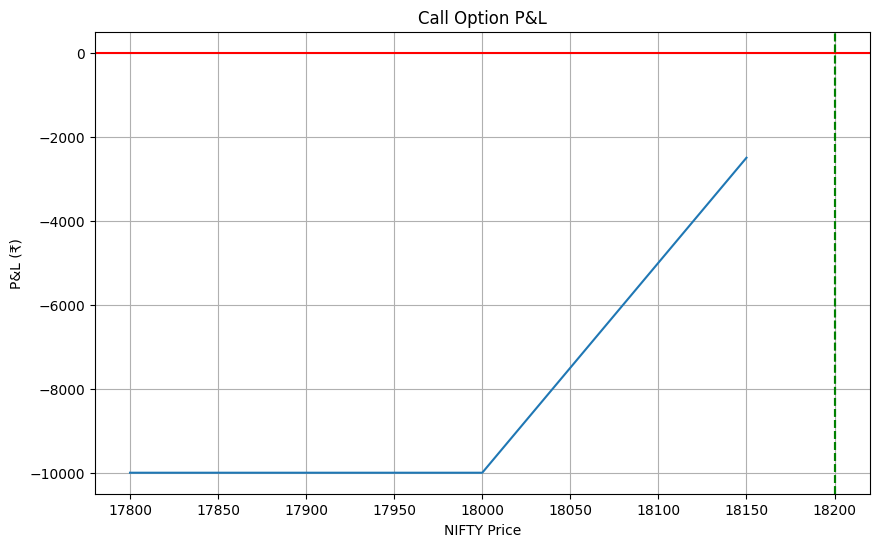

Manual breakeven calculation: 18200


In [9]:
# Create a call option leg using our OptionLeg class
call_option = OptionLeg(
    symbol="NIFTY",
    strike=18000,
    option_type="CE",
    entry_price=200,
    quantity=1,  # Quantity = 1 means one lot
    lot_size=50  # NIFTY lot size is 50
)

# Calculate P&L at different price points
price_points = np.arange(17800, 18200, 50)
payoffs = [combined_payoff([call_option], price) for price in price_points]

# Find breakeven points
breakevens = find_breakeven_points([call_option])
print(f"Breakeven points: {breakevens}")

# Plot the P&L curve
plt.figure(figsize=(10, 6))
plt.plot(price_points, payoffs)
plt.axhline(y=0, color='r', linestyle='-')
for be in breakevens:
    plt.axvline(x=be, color='g', linestyle='--')
plt.xlabel('NIFTY Price')
plt.ylabel('P&L (₹)')
plt.title('Call Option P&L')
plt.grid(True)
plt.show()

# Verification: Manual calculation
# For a long call, breakeven = strike + premium
manual_breakeven = call_option.strike + call_option.entry_price
print(f"Manual breakeven calculation: {manual_breakeven}")

Straddle breakeven points: [17600.0, 17600.0, 18400.0, 18400.0]


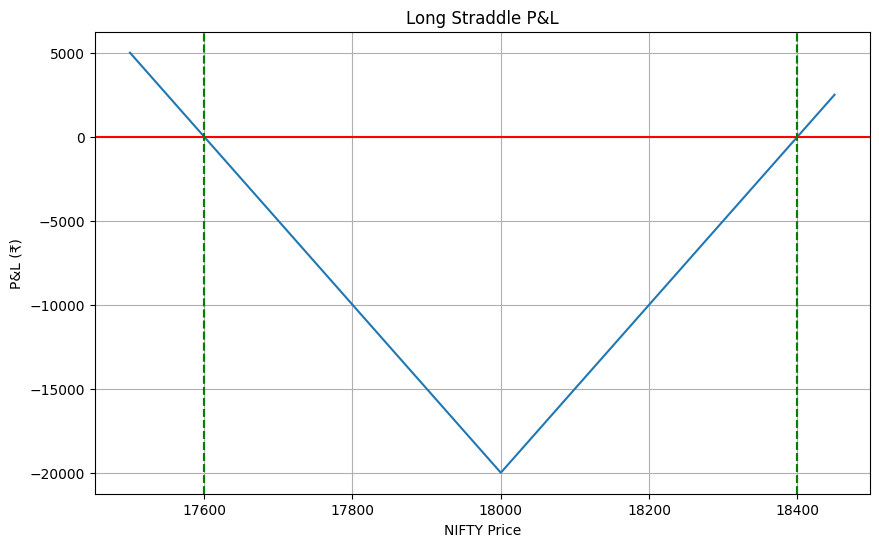

Manual straddle breakevens: 17800 and 18200


In [10]:
#Straddle Example
# Create option legs for a straddle at 18000 (buy call and put)
straddle_legs = [
    OptionLeg(
        symbol="NIFTY",
        strike=18000,
        option_type="CE",
        entry_price=200,
        quantity=1,
        lot_size=50
    ),
    OptionLeg(
        symbol="NIFTY",
        strike=18000,
        option_type="PE",
        entry_price=200,
        quantity=1,
        lot_size=50
    )
]

# Calculate P&L at different price points for straddle
price_points = np.arange(17500, 18500, 50)
straddle_payoffs = [combined_payoff(straddle_legs, price) for price in price_points]

# Find breakeven points for straddle
straddle_breakevens = find_breakeven_points(straddle_legs)
print(f"Straddle breakeven points: {straddle_breakevens}")

# Plot the P&L curve for straddle
plt.figure(figsize=(10, 6))
plt.plot(price_points, straddle_payoffs)
plt.axhline(y=0, color='r', linestyle='-')
for be in straddle_breakevens:
    plt.axvline(x=be, color='g', linestyle='--')
plt.xlabel('NIFTY Price')
plt.ylabel('P&L (₹)')
plt.title('Long Straddle P&L')
plt.grid(True)
plt.show()

# Verification: Manual calculation
# For straddle, breakevens = strike - put_premium and strike + call_premium
call_premium = straddle_legs[0].entry_price
put_premium = straddle_legs[1].entry_price
strike = straddle_legs[0].strike
manual_breakeven_lower = strike - put_premium
manual_breakeven_upper = strike + call_premium
print(f"Manual straddle breakevens: {manual_breakeven_lower} and {manual_breakeven_upper}")

In [11]:
# Cell 5 - Greeks Calculation for Options

from math import log, sqrt, exp
from scipy.stats import norm

def calculate_option_greeks(option_leg, 
                           spot_price, 
                           time_to_expiry_years,
                           risk_free_rate=0.05,  # 5% annual rate
                           volatility=0.20):      # 20% volatility
    """
    Calculate option Greeks (Delta, Gamma, Theta, Vega) using Black-Scholes model.
    
    Args:
        option_leg: OptionLeg object
        spot_price: Current price of the underlying
        time_to_expiry_years: Time to expiry in years (e.g., 30/365 for 30 days)
        risk_free_rate: Risk-free interest rate (annual)
        volatility: Implied volatility (annual)
        
    Returns:
        dict: Dictionary with calculated Greeks
    """
    S = spot_price
    K = option_leg.strike
    T = time_to_expiry_years
    r = risk_free_rate
    sigma = volatility
    
    # Prevent division by zero or negative time
    if T <= 0:
        return {
            "delta": 1.0 if option_leg.option_type == "CE" and S > K else 0.0,
            "gamma": 0.0,
            "theta": 0.0,
            "vega": 0.0,
            "theta_gamma_ratio": float('inf')  # Infinity for expired options
        }
    
    # Calculate d1 and d2 parameters
    d1 = (log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    
    # Calculate option price using Black-Scholes
    if option_leg.option_type == "CE":  # Call option
        delta = norm.cdf(d1)
        price = S * delta - K * exp(-r * T) * norm.cdf(d2)
    else:  # Put option
        delta = -norm.cdf(-d1)
        price = K * exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    # Calculate Greeks
    gamma = norm.pdf(d1) / (S * sigma * sqrt(T))
    
    # Theta (daily)
    if option_leg.option_type == "CE":
        theta = (-S * norm.pdf(d1) * sigma / (2 * sqrt(T)) - r * K * exp(-r * T) * norm.cdf(d2)) / 365
    else:
        theta = (-S * norm.pdf(d1) * sigma / (2 * sqrt(T)) + r * K * exp(-r * T) * norm.cdf(-d2)) / 365
    
    # Vega (for 1% change in volatility)
    vega = S * sqrt(T) * norm.pdf(d1) / 100
    
    # Calculate quantity-adjusted Greeks
    quantity = option_leg.quantity * option_leg.lot_size
    
    greeks = {
        "price": price,
        "delta": delta * quantity,
        "gamma": gamma * quantity,
        "theta": theta * quantity,
        "vega": vega * quantity,
    }
    
    # Calculate Theta/Gamma ratio (absolute value because we want efficiency regardless of direction)
    # Use a small epsilon to prevent division by zero
    epsilon = 1e-10
    greeks["theta_gamma_ratio"] = abs(theta) / (abs(gamma) + epsilon)
    
    return greeks

# Test Greeks calculation on our call option
test_greeks = calculate_option_greeks(
    call_option,
    spot_price=18000,  # Current price
    time_to_expiry_years=30/365  # 30 days to expiry
)

print("Greeks for Call Option at 18000:")
for greek, value in test_greeks.items():
    print(f"{greek}: {value:.4f}")

# Test Greeks calculation on straddle
straddle_greeks = {}
for i, leg in enumerate(straddle_legs):
    leg_greeks = calculate_option_greeks(
        leg,
        spot_price=18000,
        time_to_expiry_years=30/365
    )
    straddle_greeks[f"Leg {i+1} ({leg.option_type})"] = leg_greeks

# Calculate combined Greeks for straddle
combined_greeks = {
    "delta": sum(g["delta"] for g in straddle_greeks.values()),
    "gamma": sum(g["gamma"] for g in straddle_greeks.values()),
    "theta": sum(g["theta"] for g in straddle_greeks.values()),
    "vega": sum(g["vega"] for g in straddle_greeks.values()),
}
# Calculate combined Theta/Gamma ratio
combined_greeks["theta_gamma_ratio"] = abs(combined_greeks["theta"]) / (abs(combined_greeks["gamma"]) + 1e-10)

print("\nCombined Greeks for Straddle:")
for greek, value in combined_greeks.items():
    print(f"{greek}: {value:.4f}")

Greeks for Call Option at 18000:
price: 448.8078
delta: 26.9982
gamma: 0.0192
theta: -404.8934
vega: 1024.1897
theta_gamma_ratio: 21055.4031

Combined Greeks for Straddle:
delta: 3.9964
gamma: 0.0385
theta: -687.0048
vega: 2048.3795
theta_gamma_ratio: 17862.9310


In [12]:
# Cell 6 - SafeStrike Adjustment Logic

def find_adjustment_options(
    current_legs,
    target_breakeven,
    available_strikes=None,
    days_to_expiry=30,
    current_spot=18000,
    volatility=0.20,
    max_quantity=3,
):
    """
    Find all possible adjustments to move the breakeven to the target price.
    
    Args:
        current_legs: List of current OptionLeg positions
        target_breakeven: The desired breakeven point
        available_strikes: List of available strikes to try (if None, generated around spot)
        days_to_expiry: Days to expiry for new positions
        current_spot: Current spot price
        volatility: Implied volatility to use for pricing
        max_quantity: Maximum quantity to consider for new positions
    
    Returns:
        List of adjustment options sorted by Theta/Gamma ratio
    """
    # Calculate current breakevens
    current_breakevens = find_breakeven_points(current_legs)
    if not current_breakevens:
        print("No current breakeven points found. Check your position.")
        return []
    
    print(f"Current breakeven points: {current_breakevens}")
    
    # Find the closest current breakeven to target
    closest_be = min(current_breakevens, key=lambda x: abs(x - target_breakeven))
    print(f"Closest current breakeven: {closest_be}")
    print(f"Target breakeven: {target_breakeven}")
    
    # If we don't have available strikes, generate them
    if available_strikes is None:
        min_strike = max(10000, current_spot - 2000)  # Reasonable lower bound
        max_strike = current_spot + 2000  # Reasonable upper bound
        step = 100  # Typical step size for index options
        available_strikes = list(range(int(min_strike), int(max_strike) + step, step))
    
    # List to store all adjustment options
    adjustment_options = []
    
    # Try all combinations of:
    # - Strike prices
    # - Option types (CE/PE)
    # - Buy/Sell (positive/negative quantity)
    # - Quantities (1 to max_quantity)
    
    for strike in available_strikes:
        for option_type in ["CE", "PE"]:
            # Calculate theoretical price for this option
            temp_leg = OptionLeg(
                symbol="NIFTY",
                strike=strike,
                option_type=option_type,
                entry_price=0,  # Will be calculated
                quantity=1,
                lot_size=50
            )
            
            # Calculate price using BS model
            greeks = calculate_option_greeks(
                temp_leg,
                spot_price=current_spot,
                time_to_expiry_years=days_to_expiry/365,
                volatility=volatility
            )
            option_price = greeks["price"]
            
            # Try both buying and selling
            for buy_or_sell in [1, -1]:  # 1 = buy, -1 = sell
                for quantity in range(1, max_quantity + 1):
                    # Create adjustment leg
                    adj_leg = OptionLeg(
                        symbol="NIFTY",
                        strike=strike,
                        option_type=option_type,
                        entry_price=option_price,
                        quantity=quantity * buy_or_sell,
                        lot_size=50
                    )
                    
                    # Add this leg to current legs
                    test_legs = current_legs + [adj_leg]
                    
                    # Calculate new breakevens
                    new_breakevens = find_breakeven_points(test_legs)
                    
                    # If we have at least one breakeven and the target is close to one of them
                    if new_breakevens:
                        # Find the closest new breakeven to the target
                        closest_new_be = min(new_breakevens, key=lambda x: abs(x - target_breakeven))
                        
                        # If this brings us closer to target
                        if abs(closest_new_be - target_breakeven) < abs(closest_be - target_breakeven):
                            # Calculate Greeks for the adjustment
                            adj_greeks = calculate_option_greeks(
                                adj_leg,
                                spot_price=current_spot,
                                time_to_expiry_years=days_to_expiry/365,
                                volatility=volatility
                            )
                            
                            # Calculate combined Greeks for the new position
                            combined_greeks = {
                                "delta": 0,
                                "gamma": 0,
                                "theta": 0,
                                "vega": 0
                            }
                            
                            # Add Greeks from current legs
                            for leg in current_legs:
                                leg_greeks = calculate_option_greeks(
                                    leg,
                                    spot_price=current_spot,
                                    time_to_expiry_years=days_to_expiry/365,
                                    volatility=volatility
                                )
                                for greek in combined_greeks:
                                    combined_greeks[greek] += leg_greeks[greek]
                            
                            # Add Greeks from adjustment leg
                            for greek in combined_greeks:
                                combined_greeks[greek] += adj_greeks[greek]
                            
                            # Calculate Theta/Gamma ratio
                            epsilon = 1e-10
                            combined_greeks["theta_gamma_ratio"] = abs(combined_greeks["theta"]) / (abs(combined_greeks["gamma"]) + epsilon)
                            
                            # Calculate adjustment cost
                            adjustment_cost = adj_leg.total_quantity * option_price
                            if buy_or_sell < 0:
                                adjustment_cost = -adjustment_cost  # Selling gives you credit
                            
                            # Add this adjustment option
                            adjustment_options.append({
                                "adjustment_leg": adj_leg,
                                "new_breakevens": new_breakevens,
                                "closest_breakeven": closest_new_be,
                                "adjustment_cost": adjustment_cost,
                                "combined_greeks": combined_greeks,
                                "theta_gamma_ratio": combined_greeks["theta_gamma_ratio"],
                                "distance_to_target": abs(closest_new_be - target_breakeven)
                            })
    
    # Sort by how close we get to the target breakeven first
    # Then by Theta/Gamma ratio (smaller is better)
    adjustment_options.sort(key=lambda x: (x["distance_to_target"], x["theta_gamma_ratio"]))
    
    return adjustment_options[:10]  # Return top 10 options

# Let's test the adjustment function with our straddle example
# Suppose we want to move the upper breakeven from 18,200 to 18,500

adjustment_results = find_adjustment_options(
    current_legs=straddle_legs,
    target_breakeven=18500,
    current_spot=18000,
    days_to_expiry=30
)

# Display results
print("\nTop adjustment options to move breakeven to 18,500:")
for i, option in enumerate(adjustment_results[:5]):  # Show top 5
    leg = option["adjustment_leg"]
    action = "BUY" if leg.quantity > 0 else "SELL"
    print(f"\nOption {i+1}:")
    print(f"  {action} {abs(leg.quantity)} x {leg.strike} {leg.option_type} @ ₹{leg.entry_price:.2f}")
    print(f"  New breakevens: {option['new_breakevens']}")
    print(f"  Adjustment cost: ₹{option['adjustment_cost']:.2f}")
    print(f"  Theta/Gamma ratio: {option['theta_gamma_ratio']:.4f}")
    print(f"  Distance to target: {option['distance_to_target']:.2f}")

Current breakeven points: [17600.0, 17600.0, 18400.0, 18400.0]
Closest current breakeven: 18400.0
Target breakeven: 18500

Top adjustment options to move breakeven to 18,500:

Option 1:
  BUY 1 x 19000 CE @ ₹111.96
  New breakevens: [17510.0, 18500.0]
  Adjustment cost: ₹5597.93
  Theta/Gamma ratio: 18293.0785
  Distance to target: 0.00

Option 2:
  SELL 2 x 18000 CE @ ₹448.81
  New breakevens: [18500.0]
  Adjustment cost: ₹44880.78
  Theta/Gamma ratio: 1227820492312.0325
  Distance to target: 0.00

Option 3:
  BUY 3 x 19700 CE @ ₹31.41
  New breakevens: [17504.5, 18499.0]
  Adjustment cost: ₹4710.93
  Theta/Gamma ratio: 18262.8541
  Distance to target: 1.00

Option 4:
  BUY 3 x 16600 PE @ ₹30.07
  New breakevens: [17528.0, 18497.0]
  Adjustment cost: ₹4509.86
  Theta/Gamma ratio: 17392.9350
  Distance to target: 3.00

Option 5:
  BUY 2 x 16900 PE @ ₹59.33
  New breakevens: [17505.5, 18504.5]
  Adjustment cost: ₹5933.50
  Theta/Gamma ratio: 17317.4418
  Distance to target: 4.50
